In [1]:
import os
import torch
import pandas as pd
import altair as alt

from src.baseline.baseline import train_df, figures_root
from src.finetune.finetuner import run_train, run_inference
from src.baseline.utils import calculate_class_distribution, calculate_metrics

2025-12-04 17:27:02.516802: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 17:27:02.981536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 17:27:03.915051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✓ All random seeds set to 42
training files: ['train_en.csv', 'train_it.csv', 'train_es.csv']
Total training samples: 2988
CLASS DISTRIBUTION

Overall:
  Class 0 (NOT_RECLAMATORY): 2560 (85.7%)
  Class 1 (RECLAMATORY): 428 (14.3%)
  Total: 2988

Per Language:
  EN: Class 0=938, Class 1=88, Total=1026
  ES: Class 0=743, Class 1=133, Total=876
  IT: Class 0=879, Class 1=207, Total=1086




In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
original_data = train_df
augmented_data = pd.read_csv("../data/augmented_multilingual_tweets.csv")
print(original_data.shape, augmented_data.shape)

(2988, 5) (5976, 8)


In [4]:
merged_data = pd.concat([original_data, augmented_data[list(original_data.columns)]], ignore_index=True)
print(merged_data.shape)

(8964, 5)


In [5]:
train_data = augmented_data

In [6]:
calculate_class_distribution(train_data)

CLASS DISTRIBUTION

Overall:
  Class 0 (NOT_RECLAMATORY): 5120 (85.7%)
  Class 1 (RECLAMATORY): 856 (14.3%)
  Total: 5976

Per Language:
  EN: Class 0=1622, Class 1=340, Total=1962
  ES: Class 0=1817, Class 1=295, Total=2112
  IT: Class 0=1681, Class 1=221, Total=1902




# Fine-Tuning on Merged Data

In [7]:
class Config:
    """Configuration for fine-tuning"""

    # Model configuration
    MODEL_NAME = "../fine_tuned_models_mlm/twitter-xlm-roberta-base/final_MLM_model/model" #"cardiffnlp/twitter-xlm-roberta-base"  # Base model
    NUM_LABELS = 2  # Binary classification
    MAX_LENGTH = 128  # Maximum sequence length
    NUM_FROZEN_LAYERS = 3  # Number of initial layers to freeze (0 = only train classification head)

    # Training configuration
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 0.01
    NUM_EPOCHS = 10
    BATCH_SIZE = 8
    GRADIENT_ACCUMULATION_STEPS = 2
    WARMUP_RATIO = 0.1  # Warmup as % of total steps

    # Early stopping
    PATIENCE = 3
    EVAL_STRATEGY = "epoch"  # Evaluate at end of each epoch

    # Cross-validation
    N_SPLITS = 5
    TRAIN_RATIO = 0.8  # 80% for training from each fold
    VAL_RATIO = 0.2  # 20% for validation from each fold

    # Dynamic undersampling
    DYNAMIC_UNDERSAMPLE = False  # Balance classes per epoch

    # Model saving
    MAX_MODELS_TO_SAVE = 2
    OUTPUT_DIR = "../fine_tuned_models"
    RESULTS_DIR = "../results/roberta-fine-tune/augumented/"

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training would be start on the device: {DEVICE}")

Training would be start on the device: cuda


In [8]:
best_checkpoint_path = run_train(train_data, Config)

2025-12-04 12:37:27,861 - INFO - Fold 0: Train=3824, Val=956
2025-12-04 12:37:27,861 - INFO -   Train label dist: {0: 3276, 1: 548}
2025-12-04 12:37:27,862 - INFO -   Train lang dist: {'es': 1352, 'en': 1255, 'it': 1217}
2025-12-04 12:37:27,866 - INFO - Fold 1: Train=3824, Val=957
2025-12-04 12:37:27,866 - INFO -   Train label dist: {0: 3277, 1: 547}
2025-12-04 12:37:27,867 - INFO -   Train lang dist: {'es': 1352, 'en': 1255, 'it': 1217}
2025-12-04 12:37:27,870 - INFO - Fold 2: Train=3824, Val=957
2025-12-04 12:37:27,871 - INFO -   Train label dist: {0: 3277, 1: 547}
2025-12-04 12:37:27,871 - INFO -   Train lang dist: {'es': 1352, 'en': 1256, 'it': 1216}
2025-12-04 12:37:27,875 - INFO - Fold 3: Train=3824, Val=957
2025-12-04 12:37:27,875 - INFO -   Train label dist: {0: 3278, 1: 546}
2025-12-04 12:37:27,876 - INFO -   Train lang dist: {'es': 1352, 'en': 1255, 'it': 1217}
2025-12-04 12:37:27,880 - INFO - Fold 4: Train=3824, Val=957
2025-12-04 12:37:27,880 - INFO -   Train label dist: {0


FOLD 0:
  Train: 548 positive samples
  Val:   137 positive samples


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ../fine_tuned_models_mlm/twitter-xlm-roberta-base/final_MLM_model/model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-12-04 12:37:28,690 - INFO - Froze: Embeddings + First 3 Encoder Layers
2025-12-04 12:37:28,691 - INFO - Trainable: Classification Head + Remaining Encoder Layers
2025-12-04 12:37:28,691 - INFO - Trainable parameters: 64,382,978 / 278,045,186 (23.16%)
2025-12-04 12:37:28,692 - INFO - Label weights: {0: 0.5836385836385837, 1: 3.489051094890511}
2025-12-04 12:37:28,692 - INFO - Language weights: {'es': 0.9409641154628656, 'en': 1.0136920192078043, 'it': 1.0453438653293299}
2025-12-04 12:37:28,692 - INFO - Pos weight (for BCE): 5.9781
2025-12-04 12:37:28,693 - INFO - 
E


FOLD 1:
  Train: 547 positive samples
  Val:   138 positive samples


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ../fine_tuned_models_mlm/twitter-xlm-roberta-base/final_MLM_model/model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-12-04 12:38:27,829 - INFO - Froze: Embeddings + First 3 Encoder Layers
2025-12-04 12:38:27,829 - INFO - Trainable: Classification Head + Remaining Encoder Layers
2025-12-04 12:38:27,830 - INFO - Trainable parameters: 64,382,978 / 278,045,186 (23.16%)
2025-12-04 12:38:27,832 - INFO - Label weights: {0: 0.5834604821483064, 1: 3.495429616087751}
2025-12-04 12:38:27,832 - INFO - Language weights: {'es': 0.9409641154628656, 'en': 1.0136920192078043, 'it': 1.0453438653293299}
2025-12-04 12:38:27,832 - INFO - Pos weight (for BCE): 5.9909
2025-12-04 12:38:27,834 - INFO - 
E


FOLD 2:
  Train: 547 positive samples
  Val:   138 positive samples


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ../fine_tuned_models_mlm/twitter-xlm-roberta-base/final_MLM_model/model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-12-04 12:40:56,503 - INFO - Froze: Embeddings + First 3 Encoder Layers
2025-12-04 12:40:56,504 - INFO - Trainable: Classification Head + Remaining Encoder Layers
2025-12-04 12:40:56,504 - INFO - Trainable parameters: 64,382,978 / 278,045,186 (23.16%)
2025-12-04 12:40:56,505 - INFO - Label weights: {0: 0.5834604821483064, 1: 3.495429616087751}
2025-12-04 12:40:56,506 - INFO - Language weights: {'es': 0.9409476243674836, 'en': 1.0128671880134061, 'it': 1.0461851876191102}
2025-12-04 12:40:56,506 - INFO - Pos weight (for BCE): 5.9909
2025-12-04 12:40:56,507 - INFO - 
E


FOLD 3:
  Train: 546 positive samples
  Val:   138 positive samples


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ../fine_tuned_models_mlm/twitter-xlm-roberta-base/final_MLM_model/model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-12-04 12:41:54,647 - INFO - Froze: Embeddings + First 3 Encoder Layers
2025-12-04 12:41:54,647 - INFO - Trainable: Classification Head + Remaining Encoder Layers
2025-12-04 12:41:54,648 - INFO - Trainable parameters: 64,382,978 / 278,045,186 (23.16%)
2025-12-04 12:41:54,649 - INFO - Label weights: {0: 0.5832824893227577, 1: 3.501831501831502}
2025-12-04 12:41:54,649 - INFO - Language weights: {'es': 0.9409641154628656, 'en': 1.0136920192078043, 'it': 1.0453438653293299}
2025-12-04 12:41:54,649 - INFO - Pos weight (for BCE): 6.0037
2025-12-04 12:41:54,651 - INFO - 
E


FOLD 4:
  Train: 547 positive samples
  Val:   138 positive samples


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ../fine_tuned_models_mlm/twitter-xlm-roberta-base/final_MLM_model/model and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-12-04 12:42:52,745 - INFO - Froze: Embeddings + First 3 Encoder Layers
2025-12-04 12:42:52,746 - INFO - Trainable: Classification Head + Remaining Encoder Layers
2025-12-04 12:42:52,746 - INFO - Trainable parameters: 64,382,978 / 278,045,186 (23.16%)
2025-12-04 12:42:52,747 - INFO - Label weights: {0: 0.5834604821483064, 1: 3.495429616087751}
2025-12-04 12:42:52,748 - INFO - Language weights: {'es': 0.9416953224870754, 'en': 1.0129222776114961, 'it': 1.045382399901429}
2025-12-04 12:42:52,748 - INFO - Pos weight (for BCE): 5.9909
2025-12-04 12:42:52,749 - INFO - 
Ep

### Visualizing Fine-Tune Metrics

In [9]:
df = pd.read_csv(os.path.join(Config.RESULTS_DIR, "training_results.csv"))

In [10]:
f1_plot = alt.Chart(df).mark_line(point=True, size=3).encode(
    x=alt.X('epoch:Q', title='Epoch'),
    y=alt.Y('overall_macro_f1:Q', title='Macro F1 Score', scale=alt.Scale(domain=[0.3, 0.8])),
    color=alt.Color('fold:N', title='Fold'),
    tooltip=['fold:N', 'epoch:Q', alt.Tooltip('overall_macro_f1:Q', format='.4f')]
).properties(width=600, height=300, title='Overall F1 Score by Fold')
f1_plot.save(os.path.join(figures_root, 'f1_vs_fold_augmented.svg'))
os.path.join(figures_root, 'f1_vs_fold_augmented.svg')

'../figures/f1_vs_fold_augmented.svg'

![](../figures/f1_vs_fold_augmented.svg)

In [11]:
loss_data = df[['fold', 'epoch', 'train_loss', 'val_loss']].melt(
    id_vars=['fold', 'epoch'], var_name='loss_type', value_name='loss'
)

loss_plot = alt.Chart(loss_data).mark_line(point=True).encode(
    x='epoch:Q', y='loss:Q', color='loss_type:N', strokeDash='fold:N',
    tooltip=['fold:N', 'epoch:Q', 'loss_type:N', alt.Tooltip('loss:Q', format='.4f')]
).properties(width=600, height=300, title='Training & Validation Loss')

loss_plot.save(os.path.join(figures_root, 'loss_augmented.svg'))
os.path.join(figures_root, 'loss_augmented.svg')

'../figures/loss_augmented.svg'

![](../figures/loss_augmented.svg)

In [12]:
lang_data = df[['fold', 'epoch', 'en_macro_f1', 'es_macro_f1', 'it_macro_f1']].melt(
    id_vars=['fold', 'epoch'], var_name='language', value_name='f1'
)
lang_data['language'] = lang_data['language'].str.replace('_macro_f1', '').str.upper()

lang_plot = alt.Chart(lang_data).mark_line(point=True).encode(
    x='epoch:Q', y=alt.Y('f1:Q', scale=alt.Scale(domain=[0.4, 0.95])), color='language:N', strokeDash='fold:N',
    tooltip=['fold:N', 'epoch:Q', 'language:N', alt.Tooltip('f1:Q', format='.4f')]
).properties(width=600, height=300, title='F1 by Language')

lang_plot.save(os.path.join(figures_root, 'f1_vs_lang_augmented.svg'))
os.path.join(figures_root, 'f1_vs_lang_augmented.svg')

'../figures/f1_vs_lang_augmented.svg'

![](../figures/f1_vs_lang_augmented.svg)

In [13]:
metrics_data = df[['fold', 'epoch', 'overall_macro_precision', 'overall_macro_recall', 'overall_macro_f1']].melt(
    id_vars=['fold', 'epoch'], var_name='metric', value_name='value'
)
metrics_data['metric'] = metrics_data['metric'].str.replace('overall_macro_', '').str.capitalize()
metrics_data['fold_epoch'] = 'F' + metrics_data['fold'].astype(str) + ':E' + metrics_data['epoch'].astype(str)

heatmap = alt.Chart(metrics_data).mark_rect().encode(
    x='fold_epoch:O', y='metric:N',
    color=alt.Color('value:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['fold_epoch:N', 'metric:N', alt.Tooltip('value:Q', format='.4f')]
).properties(width=700, height=150, title='Precision/Recall/F1 Heatmap')

heatmap.save(os.path.join(figures_root, 'fold_vs_epoch_augmented.svg'))
os.path.join(figures_root, 'fold_vs_epoch_augmented.svg')

'../figures/fold_vs_epoch_augmented.svg'

![](../figures/fold_vs_epoch_augmented.svg)

# Inference

In [3]:
class InferenceConfig:
    MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base"
    CHECKPOINT_PATH = "../fine_tuned_mlm_models_optuna/final_model/checkpoints/fold_0_epoch_8_f1_0.7845.pt" #best_checkpoint_path
    MAX_LENGTH = 128
    BATCH_SIZE = 32
    NUM_LABELS = 2
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
results = run_inference(train_df, InferenceConfig)

Running inference on 2988 samples...
Device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded checkpoint from: ../fine_tuned_mlm_models_optuna/final_model/checkpoints/fold_0_epoch_8_f1_0.7845.pt


Inference: 100%|██████████| 94/94 [00:02<00:00, 37.21it/s]


INFERENCE RESULTS ON TRAIN DATA

Overall Metrics:
  Macro Precision: 0.6618
  Macro Recall:    0.7680
  Macro F1:        0.6811

Per-Language Metrics:
  EN:
    Precision: 0.5552
    Recall:    0.6684
    F1:        0.5061
  ES:
    Precision: 0.6933
    Recall:    0.8240
    F1:        0.7145
  IT:
    Precision: 0.8914
    Recall:    0.8269
    F1:        0.8540


In [6]:
results.keys()

dict_keys(['predictions', 'probabilities', 'labels', 'languages', 'metrics'])

In [9]:
results["probabilities"][-1]

[0.5591304898262024, 0.44086953997612]

# Threshold Analysis

In [11]:
import numpy as np

In [13]:
probs = np.array(results['probabilities'])  # Shape: (N_samples, 2)
labels = np.array(results['labels'])
languages = np.array(results['languages'])

# Probability of positive class (class 1):
probs_class_1 = probs[:, 1]  # Shape: (N_samples,)

print(f"Shape: {probs_class_1.shape}")
print(f"Min: {probs_class_1.min():.4f}, Max: {probs_class_1.max():.4f}")
print(f"Mean: {probs_class_1.mean():.4f}, Std: {probs_class_1.std():.4f}")

Shape: (2988,)
Min: 0.0023, Max: 1.0000
Mean: 0.3648, Std: 0.2652


In [14]:
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc
)
import pandas as pd
import matplotlib.pyplot as plt

def analyze_threshold_performance(probs_class_1, labels, languages, 
                                   thresholds=None, language_specific=True):
    
    if thresholds is None:
        thresholds = np.arange(0.05, 1.0, 0.05)
    
    results = []
    
    for threshold in thresholds:
        predictions = (probs_class_1 >= threshold).astype(int)
        macro_precision = precision_score(labels, predictions, average="macro", zero_division=0)
        macro_recall = recall_score(labels, predictions, average="macro", zero_division=0)
        macro_f1 = f1_score(labels, predictions, average="macro", zero_division=0)
        
        row = {
            "threshold": threshold,
            "overall_precision": macro_precision,
            "overall_recall": macro_recall,
            "overall_f1": macro_f1,
        }
        
        if language_specific:
            unique_langs = set(languages)
            for lang in sorted(unique_langs):
                lang_mask = np.array(languages) == lang
                lang_preds = predictions[lang_mask]
                lang_labels = np.array(labels)[lang_mask]
                
                if len(lang_labels) > 0 and len(np.unique(lang_labels)) > 1:
                    lang_f1 = f1_score(lang_labels, lang_preds, average="macro", zero_division=0)
                    row[f"{lang}_f1"] = lang_f1
                else:
                    row[f"{lang}_f1"] = 0.0
        
        results.append(row)
    
    return pd.DataFrame(results)


def plot_threshold_analysis(threshold_df):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ax = axes[0, 0]
    ax.plot(threshold_df["threshold"], threshold_df["overall_f1"], 
            marker='o', linewidth=2, markersize=6, label="Overall F1")
    ax.set_xlabel("Probability Threshold")
    ax.set_ylabel("F1 Score")
    ax.set_title("Overall F1 Score vs Threshold")
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label="Default (0.5)")
    best_threshold = threshold_df.loc[threshold_df["overall_f1"].idxmax(), "threshold"]
    ax.axvline(x=best_threshold, color='g', linestyle='--', alpha=0.5, label=f"Best ({best_threshold:.2f})")
    ax.legend()
    
    # Plot 2: Precision vs Recall
    ax = axes[0, 1]
    ax.plot(threshold_df["overall_recall"], threshold_df["overall_precision"], 
            marker='o', linewidth=2, markersize=6)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision vs Recall (P-R Curve)")
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 0]
    ax.plot(threshold_df["threshold"], threshold_df["overall_precision"], 
            marker='o', label="Precision", linewidth=2)
    ax.plot(threshold_df["threshold"], threshold_df["overall_recall"], 
            marker='s', label="Recall", linewidth=2)
    ax.plot(threshold_df["threshold"], threshold_df["overall_f1"], 
            marker='^', label="F1", linewidth=2)
    ax.set_xlabel("Probability Threshold")
    ax.set_ylabel("Score")
    ax.set_title("All Metrics vs Threshold")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.axvline(x=0.5, color='r', linestyle='--', alpha=0.3)
    
    ax = axes[1, 1]
    lang_columns = [col for col in threshold_df.columns if col.endswith("_f1") and col != "overall_f1"]
    for lang_col in sorted(lang_columns):
        lang_name = lang_col.replace("_f1", "").upper()
        ax.plot(threshold_df["threshold"], threshold_df[lang_col], 
                marker='o', label=lang_name, linewidth=2)
    ax.set_xlabel("Probability Threshold")
    ax.set_ylabel("F1 Score")
    ax.set_title("Per-Language F1 vs Threshold")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.axvline(x=0.5, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig


def find_optimal_thresholds(threshold_df):
    """
    Find optimal threshold for each objective.
    """
    
    print("\n" + "="*80)
    print("OPTIMAL THRESHOLDS")
    print("="*80)
    
    best_overall = threshold_df.loc[threshold_df["overall_f1"].idxmax()]
    print(f"\nBest Overall F1: {best_overall['overall_f1']:.4f}")
    print(f"  Threshold: {best_overall['threshold']:.2f}")
    print(f"  Precision: {best_overall['overall_precision']:.4f}")
    print(f"  Recall: {best_overall['overall_recall']:.4f}")
    
    best_precision = threshold_df.loc[threshold_df["overall_precision"].idxmax()]
    print(f"\nBest Precision: {best_precision['overall_precision']:.4f}")
    print(f"  Threshold: {best_precision['threshold']:.2f}")
    print(f"  F1: {best_precision['overall_f1']:.4f}")
    
    best_recall = threshold_df.loc[threshold_df["overall_recall"].idxmax()]
    print(f"\nBest Recall: {best_recall['overall_recall']:.4f}")
    print(f"  Threshold: {best_recall['threshold']:.2f}")
    print(f"  F1: {best_recall['overall_f1']:.4f}")
    
    closest_to_default = (threshold_df["threshold"] - 0.5).abs().idxmin()
    default_metrics = threshold_df.iloc[closest_to_default]
    
    improvement = (best_overall['overall_f1'] - default_metrics['overall_f1']) / default_metrics['overall_f1'] * 100
    
    print(f"\n{'='*80}")
    print(f"DEFAULT THRESHOLD (0.5) vs OPTIMAL")
    print(f"{'='*80}")
    print(f"\nDefault (0.5):")
    print(f"  F1: {default_metrics['overall_f1']:.4f}")
    print(f"  Precision: {default_metrics['overall_precision']:.4f}")
    print(f"  Recall: {default_metrics['overall_recall']:.4f}")
    
    print(f"\nOptimal ({best_overall['threshold']:.2f}):")
    print(f"  F1: {best_overall['overall_f1']:.4f}")
    print(f"  Precision: {best_overall['overall_precision']:.4f}")
    print(f"  Recall: {best_overall['overall_recall']:.4f}")
    
    print(f"\nImprovement:")
    print(f"  F1 Change: {best_overall['overall_f1'] - default_metrics['overall_f1']:+.4f} ({improvement:+.1f}%)")
    print(f"  Precision Change: {best_overall['overall_precision'] - default_metrics['overall_precision']:+.4f}")
    print(f"  Recall Change: {best_overall['overall_recall'] - default_metrics['overall_recall']:+.4f}")
    print("="*80 + "\n")
    
    return {
        "best_threshold": best_overall['threshold'],
        "best_f1": best_overall['overall_f1'],
        "default_f1": default_metrics['overall_f1'],
        "improvement_pct": improvement
    }



                                                                                
 THRESHOLD OPTIMIZATION ANALYSIS
                                                                                


OPTIMAL THRESHOLDS

Best Overall F1: 0.6910
  Threshold: 0.60
  Precision: 0.6716
  Recall: 0.7272

Best Precision: 0.7203
  Threshold: 0.95
  F1: 0.5557

Best Recall: 0.7780
  Threshold: 0.40
  F1: 0.6443

DEFAULT THRESHOLD (0.5) vs OPTIMAL

Default (0.5):
  F1: 0.6811
  Precision: 0.6618
  Recall: 0.7680

Optimal (0.60):
  F1: 0.6910
  Precision: 0.6716
  Recall: 0.7272

Improvement:
  F1 Change: +0.0099 (+1.5%)
  Precision Change: +0.0098
  Recall Change: -0.0408

Saved: threshold_analysis.png
Saved: threshold_analysis.csv


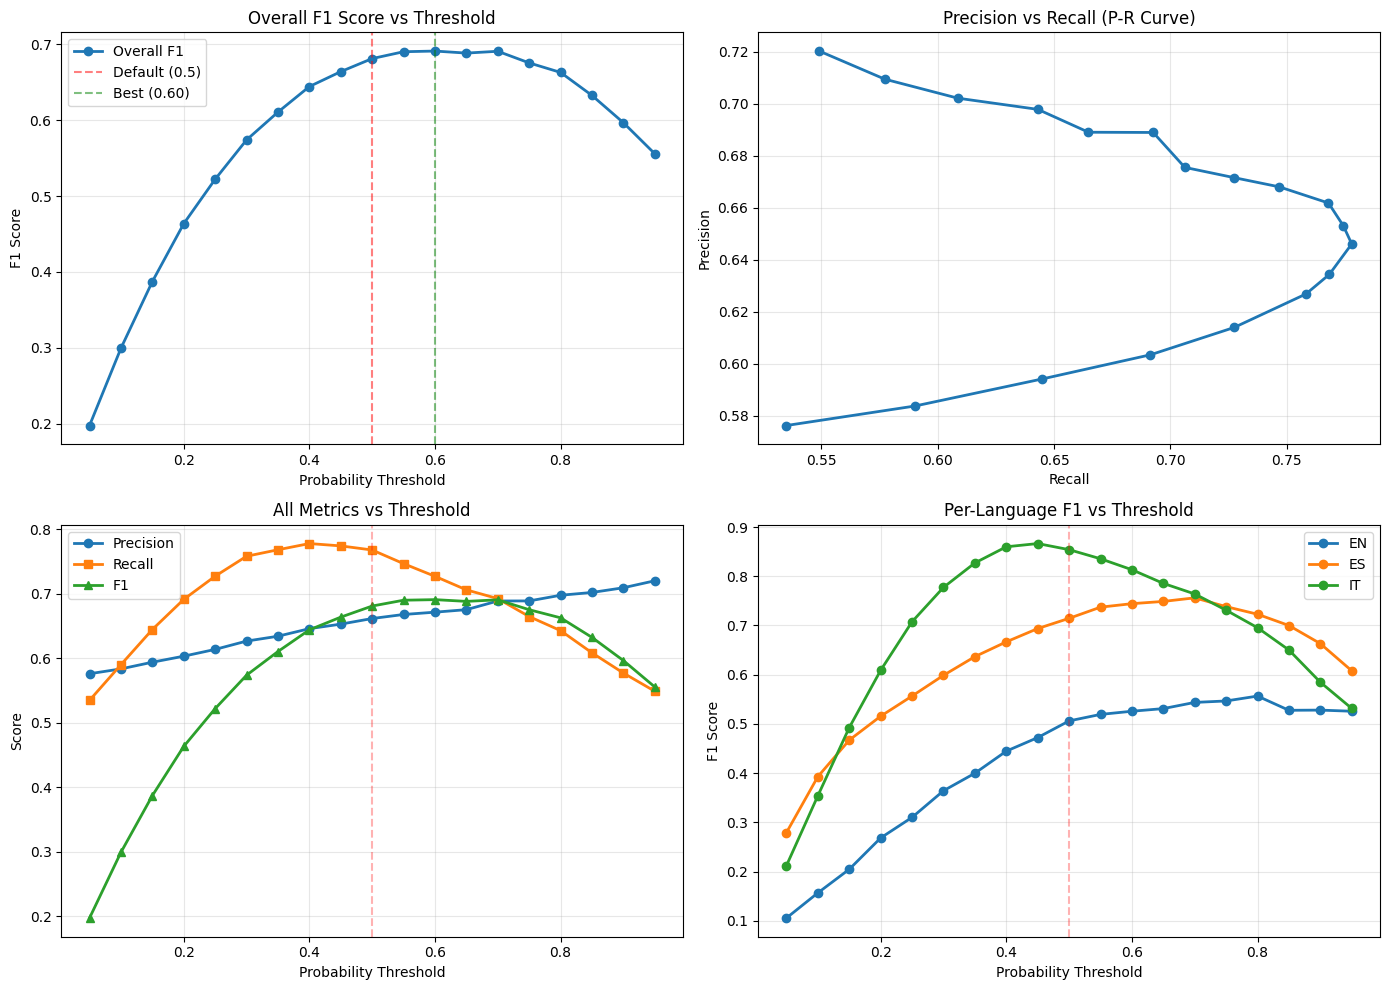

In [16]:
probs = np.array(results['probabilities'])
probs_class_1 = probs[:, 1]
labels = np.array(results['labels'])
languages = results['languages']

print("\n" + " "*80)
print(" THRESHOLD OPTIMIZATION ANALYSIS")
print(" "*80 + "\n")

threshold_df = analyze_threshold_performance(
    probs_class_1, 
    labels, 
    languages,
    thresholds=np.arange(0.05, 1.0, 0.05),
    language_specific=True
)

optimal_info = find_optimal_thresholds(threshold_df)

fig = plot_threshold_analysis(threshold_df)
plt.savefig("../figures/threshold_analysis.png", dpi=300, bbox_inches='tight')
print("Saved: threshold_analysis.png")

# Save results
threshold_df.to_csv("../results/threshold_analysis.csv", index=False)
print("Saved: threshold_analysis.csv")

In [17]:
inference_results = results

In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pandas as pd

probs = np.array(inference_results['probabilities'])  # Shape: (N, 2)
probs_class_1 = probs[:, 1]  # Get positive class probabilities
labels = np.array(inference_results['labels'])
languages = inference_results['languages']

print(f"Probability stats:")
print(f"  Min: {probs_class_1.min():.4f}")
print(f"  Max: {probs_class_1.max():.4f}")
print(f"  Mean: {probs_class_1.mean():.4f}")
print(f"  Median: {np.median(probs_class_1):.4f}")

Probability stats:
  Min: 0.0023
  Max: 1.0000
  Mean: 0.3648
  Median: 0.2976


In [19]:
results = []

for threshold in np.arange(0.1, 1.0, 0.1):
    preds = (probs_class_1 >= threshold).astype(int)
    
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    precision = precision_score(labels, preds, average="macro", zero_division=0)
    recall = recall_score(labels, preds, average="macro", zero_division=0)
    
    results.append({
        "threshold": threshold,
        "f1": f1,
        "precision": precision,
        "recall": recall
    })

threshold_df = pd.DataFrame(results)
print(threshold_df.to_string(index=False))

 threshold       f1  precision   recall
       0.1 0.299400   0.583690 0.590238
       0.2 0.463553   0.603398 0.691439
       0.3 0.573932   0.626801 0.758298
       0.4 0.644251   0.646051 0.777972
       0.5 0.681131   0.661799 0.767980
       0.6 0.691036   0.671611 0.727198
       0.7 0.690752   0.688955 0.692615
       0.8 0.662870   0.697847 0.643018
       0.9 0.596612   0.709461 0.577258


In [21]:


print("\n" + "="*80)
print("LANGUAGE-SPECIFIC OPTIMAL THRESHOLDS")
print("="*80)

language_optimal_thresholds = {}

for lang in sorted(set(languages)):
    lang_mask = np.array(languages) == lang
    lang_probs = probs_class_1[lang_mask]
    lang_labels = np.array(labels)[lang_mask]
    
    best_threshold = None
    best_f1 = 0
    best_precision = 0
    best_recall = 0
    
    # Test all thresholds for this language
    for threshold in np.arange(0.05, 1.0, 0.05):
        preds = (lang_probs >= threshold).astype(int)
        f1 = f1_score(lang_labels, preds, average="macro", zero_division=0)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision_score(lang_labels, preds, average="macro", zero_division=0)
            best_recall = recall_score(lang_labels, preds, average="macro", zero_division=0)
    
    language_optimal_thresholds[lang] = best_threshold
    
    print(f"\n{lang.upper()}:")
    print(f"  Optimal Threshold: {best_threshold:.2f}")
    print(f"  F1 Score: {best_f1:.4f}")
    print(f"  Precision: {best_precision:.4f}")
    print(f"  Recall: {best_recall:.4f}")

print("\n" + "="*80)
print("APPLYING LANGUAGE-SPECIFIC THRESHOLDS")
print("="*80)

language_specific_preds = np.zeros_like(probs_class_1, dtype=int)

for lang in sorted(set(languages)):
    lang_mask = np.array(languages) == lang
    threshold = language_optimal_thresholds[lang]
    language_specific_preds[lang_mask] = (probs_class_1[lang_mask] >= threshold).astype(int)

print("\nOVERALL METRICS COMPARISON:")
print("-" * 80)

default_preds = (probs_class_1 >= 0.5).astype(int)
default_f1 = f1_score(labels, default_preds, average="macro", zero_division=0)
default_precision = precision_score(labels, default_preds, average="macro", zero_division=0)
default_recall = recall_score(labels, default_preds, average="macro", zero_division=0)

langspec_f1 = f1_score(labels, language_specific_preds, average="macro", zero_division=0)
langspec_precision = precision_score(labels, language_specific_preds, average="macro", zero_division=0)
langspec_recall = recall_score(labels, language_specific_preds, average="macro", zero_division=0)

print(f"\nDefault Threshold (0.5):")
print(f"  F1: {default_f1:.4f}")
print(f"  Precision: {default_precision:.4f}")
print(f"  Recall: {default_recall:.4f}")

print(f"\nLanguage-Specific Thresholds:")
for lang in sorted(set(languages)):
    print(f"  {lang.upper()}: {language_optimal_thresholds[lang]:.2f}", end="")
print()

print(f"  F1: {langspec_f1:.4f}")
print(f"  Precision: {langspec_precision:.4f}")
print(f"  Recall: {langspec_recall:.4f}")

print(f"\nOverall Improvement:")
print(f"  F1 Change: {langspec_f1 - default_f1:+.4f} ({(langspec_f1/default_f1 - 1)*100:+.1f}%)")
print(f"  Precision Change: {langspec_precision - default_precision:+.4f}")
print(f"  Recall Change: {langspec_recall - default_recall:+.4f}")

print("\n" + "="*80)
print("PER-LANGUAGE COMPARISON")
print("="*80)

for lang in sorted(set(languages)):
    lang_mask = np.array(languages) == lang
    lang_labels = np.array(labels)[lang_mask]
    
    default_lang_preds = default_preds[lang_mask]
    default_lang_f1 = f1_score(lang_labels, default_lang_preds, average="macro", zero_division=0)
    default_lang_precision = precision_score(lang_labels, default_lang_preds, average="macro", zero_division=0)
    default_lang_recall = recall_score(lang_labels, default_lang_preds, average="macro", zero_division=0)
    
    langspec_lang_preds = language_specific_preds[lang_mask]
    langspec_lang_f1 = f1_score(lang_labels, langspec_lang_preds, average="macro", zero_division=0)
    langspec_lang_precision = precision_score(lang_labels, langspec_lang_preds, average="macro", zero_division=0)
    langspec_lang_recall = recall_score(lang_labels, langspec_lang_preds, average="macro", zero_division=0)
    
    print(f"\n{lang.upper()}:")
    print(f"  Default (0.5):")
    print(f"    F1: {default_lang_f1:.4f}, Precision: {default_lang_precision:.4f}, Recall: {default_lang_recall:.4f}")
    print(f"  Language-Specific ({language_optimal_thresholds[lang]:.2f}):")
    print(f"    F1: {langspec_lang_f1:.4f}, Precision: {langspec_lang_precision:.4f}, Recall: {langspec_lang_recall:.4f}")
    print(f"  Improvement: {langspec_lang_f1 - default_lang_f1:+.4f} ({(langspec_lang_f1/default_lang_f1 - 1)*100:+.1f}%)")

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT - LANGUAGE-SPECIFIC THRESHOLDS")
print("="*80)

print("\nOverall Classification Report:")
print(classification_report(labels, language_specific_preds, target_names=['Class 0', 'Class 1']))

print("\nPer-Language Classification Reports:")
for lang in sorted(set(languages)):
    lang_mask = np.array(languages) == lang
    lang_labels = np.array(labels)[lang_mask]
    lang_preds = language_specific_preds[lang_mask]
    
    print(f"\n{lang.upper()} (Threshold: {language_optimal_thresholds[lang]:.2f}):")
    print(classification_report(lang_labels, lang_preds, target_names=['Class 0', 'Class 1']))

results_df = pd.DataFrame({
    'language': list(language_optimal_thresholds.keys()),
    'optimal_threshold': list(language_optimal_thresholds.values())
})

print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(results_df.to_string(index=False))


LANGUAGE-SPECIFIC OPTIMAL THRESHOLDS

EN:
  Optimal Threshold: 0.80
  F1 Score: 0.5566
  Precision: 0.5506
  Recall: 0.5696

ES:
  Optimal Threshold: 0.70
  F1 Score: 0.7561
  Precision: 0.7398
  Recall: 0.7779

IT:
  Optimal Threshold: 0.45
  F1 Score: 0.8664
  Precision: 0.8777
  Recall: 0.8563

APPLYING LANGUAGE-SPECIFIC THRESHOLDS

OVERALL METRICS COMPARISON:
--------------------------------------------------------------------------------

Default Threshold (0.5):
  F1: 0.6811
  Precision: 0.6618
  Recall: 0.7680

Language-Specific Thresholds:
  EN: 0.80  ES: 0.70  IT: 0.45
  F1: 0.7554
  Precision: 0.7447
  Recall: 0.7680

Overall Improvement:
  F1 Change: +0.0743 (+10.9%)
  Precision Change: +0.0829
  Recall Change: -0.0000

PER-LANGUAGE COMPARISON

EN:
  Default (0.5):
    F1: 0.5061, Precision: 0.5552, Recall: 0.6684
  Language-Specific (0.80):
    F1: 0.5566, Precision: 0.5506, Recall: 0.5696
  Improvement: +0.0504 (+10.0%)

ES:
  Default (0.5):
    F1: 0.7145, Precision: 0.6